In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import sympy 
from sympy import banded, symbols, print_latex, oo
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import wofz 
import pickle

In [3]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Hermite Linear Response Function w/ Hypercollisionality

In [4]:
# number of moments
Nv = 4
# hyperviscosity order
alpha = 1

In [5]:
# symbolic variables
xi = symbols('xi') 
nu = symbols('nu', real = True) # must be real and not complex
k = symbols('k', integer = True) # must be an integer from defintion

In [6]:
# advection matrix (off-diagonal)
vec = sympy.zeros(Nv)
for jj in range(1, Nv+1):
    vec[jj-1] = sympy.sqrt(jj)/ (sympy.sqrt(2))

In [7]:
def factorial_ratio(n, m):
    if n >= m:
        return np.prod(range(m + 1, n + 1))
    else:
        return 1 / np.prod(range(n + 1, m + 1))

In [8]:
# advection matrix (main-diagonal)
vec2 = sympy.zeros(Nv)
for jj in range(alpha, Nv+1):
    # hyper collisions coefficient
        vec2[jj] = sympy.Rational(factorial_ratio(n=jj, m=jj-2*alpha+1),  1/factorial_ratio(n=Nv - 2*alpha, m=Nv-1))

In [9]:
# enforce k=1 for simplicity now
k=1

In [10]:
# create an advection tri-diagonal matrix
A = banded({1: tuple(vec[0, :-1]), -1: tuple(vec[0, :-1]), 0: tuple(nu*vec2[0, :]/(sympy.I*sympy.sqrt(2)*k))})

In [11]:
A

Matrix([
[        0,       sqrt(2)/2,               0,               0],
[sqrt(2)/2, -sqrt(2)*I*nu/6,               1,               0],
[        0,               1, -sqrt(2)*I*nu/3,       sqrt(6)/2],
[        0,               0,       sqrt(6)/2, -sqrt(2)*I*nu/2]])

In [12]:
# idenitity matrix
I = np.eye(Nv, dtype=int)

In [13]:
# invert matrix
M = sympy.SparseMatrix(I*xi - k/ np.abs(k) * A)

In [14]:
# get final response function 
R_approx = sympy.simplify(sympy.simplify(M.inv()[0, 1]/sympy.sqrt(2) * k / np.abs(k)))


KeyboardInterrupt



In [15]:
# print 
# R_approx

In [16]:
# latex code
# print_latex(R_approx)

## Asymptotic Expansion

### Adiabatic limit $\xi \to 0$

In [ ]:
asymptotics_0 = R_approx.series(xi, 0, 2)

In [ ]:
asymptotics_0

In [ ]:
sympy.simplify(asymptotics_0.coeff(xi, 0))

In [ ]:
sympy.simplify(asymptotics_0.coeff(xi, 1))

In [ ]:
func = sympy.lambdify(nu, asymptotics_0.coeff(xi, 1) + sympy.I*sympy.sqrt(sympy.pi), modules='numpy')

In [ ]:
sol_coeff = scipy.optimize.newton(func, x0=1, maxiter=20000, rtol=1e-3, full_output=True)

In [ ]:
sol_coeff

In [ ]:
print("first coeff error = ", func(sol_coeff[0]))

In [ ]:
# save optimal nu (for k=1)
with open("optimal_nu_hyper_" + str(alpha) + "/nu_" + str(Nv) + ".txt", "wb") as outf:
    pickle.dump(sol_coeff[0], outf)

In [ ]:
# save optimal R(nu*) (for k=1)
with open("optimal_R_hyper_" + str(alpha) + "/R_" + str(Nv) + ".txt", "wb") as outf:
    pickle.dump(sympy.simplify(R_approx.subs(nu, sol_coeff[0].real)), outf)

### Fluid (cold plasma) limit $\xi \to \infty$

In [ ]:
asymptotics_inf = R_approx.series(xi, oo, 4)

In [ ]:
asymptotics_inf

In [ ]:
print_latex(asymptotics_inf)

## Comparison with Hammett-Perkins 1990's approximation

In [87]:
def Z_fun(z):
    return 1j*np.sqrt(np.pi)*wofz(z)

def R(xi):
    return -(1 + xi*Z_fun(xi))

def R_Hermite_hyper(zeta, Nv, alpha):
    with open('optimal_R_hyper_' + str(alpha) +'/R_' + str(Nv) + '.txt','rb') as f:
        return sympy.lambdify(xi, pickle.load(f))(zeta)

def R_Hermite_HP(zeta, Nv, q):
    with open('optimal_R_HP_q' + str(q) + '/R_' + str(Nv) + '.txt','rb') as f:
        return sympy.lambdify(xi, pickle.load(f))(zeta)

def R_Hermite(zeta, Nv):
    with open('optimal_R_AW/R_' + str(Nv) + '.txt','rb') as f:
        return sympy.lambdify(xi, pickle.load(f))(zeta)

def R_Hermite_filter(zeta, Nv):
    with open('optimal_R_filter/R_' + str(Nv) + '.txt','rb') as f:
        return sympy.lambdify(xi, pickle.load(f))(zeta)

In [88]:
# define the xi along the real axis 
zeta = 10**np.linspace(-2, 2, int(1e5))

In [89]:
R_true = R(zeta)

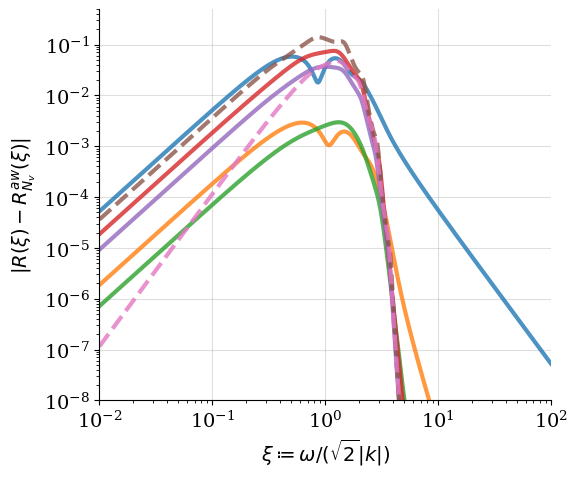

In [189]:
fig, ax = plt.subplots(figsize=(6, 5))

Nv = 12

# hypercollisions
for alpha in range(1, int(Nv/2)):
    ax.plot(zeta, np.abs(R_true - R_Hermite_hyper(zeta, Nv=Nv, alpha=alpha)), label=r"hyper $\alpha = " + str(alpha) + "$", alpha=0.8, linewidth=3, linestyle='-')

# nonlocal closure
ax.plot(zeta, np.abs(R_true -R_Hermite_HP(zeta=zeta, Nv=Nv, q=1)), label=r"closure $N_{m} = 1$", alpha=0.8, linewidth=3, linestyle='--', c="tab:brown")
ax.plot(zeta, np.abs(R_true -R_Hermite_HP(zeta=zeta, Nv=Nv, q=2)), label=r"closure $N_{m} = 3$", alpha=0.8, linewidth=3, linestyle='--', c="tab:pink")

# filtering
# ax.plot(zeta, np.abs(R_true -R_Hermite_filter(zeta=zeta, Nv=Nv)), label=r"filter", alpha=0.8, linewidth=3, linestyle=':', c="tab:gray")

ax.set_ylim(1e-8, 5e-1)
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|R(\xi) - R^{aw}_{N_{v}}(\xi)|$")
ax.set_xlabel(r"$\xi \coloneq \omega/(\sqrt{2}|k|)$")
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e2)
# legend = ax.legend(loc='upper left', ncols=1, fancybox=False, shadow=False, fontsize=12, bbox_to_anchor=(0.7, 1.25))
# legend.get_frame().set_alpha(0)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("figs/symbolic_response_function_AW_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')

In [122]:
x = np.arange(4, 14, 2)
# hypercollisions
error_hyper1 = []
error_hyper2 = []
error_hyper3 = []
error_hyper4 = []
error_hyper5 = []

# nonlocal closure
error_HP2 = []
error_HP1 = []

# filtering 
error_filter = []

for Nv in x:    
    # hypercollisions
    error_hyper1.append(np.linalg.norm(np.abs(R_true - R_Hermite_hyper(zeta, Nv=Nv, alpha=1))))
    error_hyper2.append(np.linalg.norm(np.abs(R_true - R_Hermite_hyper(zeta, Nv=Nv, alpha=2))))
    if Nv >=6:
        error_hyper3.append(np.linalg.norm(np.abs(R_true - R_Hermite_hyper(zeta, Nv=Nv, alpha=3))))
    if Nv >= 10:
        error_hyper4.append(np.linalg.norm(np.abs(R_true - R_Hermite_hyper(zeta, Nv=Nv, alpha=4))))
    if Nv >= 12:
        error_hyper5.append(np.linalg.norm(np.abs(R_true - R_Hermite_hyper(zeta, Nv=Nv, alpha=5))))

    # hammett-perkins
    error_HP2.append(np.linalg.norm(np.abs(R_true - R_Hermite_HP(zeta, Nv=Nv, q=2))))
    error_HP1.append(np.linalg.norm(np.abs(R_true - R_Hermite_HP(zeta, Nv=Nv, q=1))))

    # filtering 
    #error_HP2.append(np.linalg.norm(np.abs(R_true - R_Hermite_filter(zeta, Nv=Nv))))

In [125]:
# find the best fitting linear slope 
# hypercollisions
a_hyper1, b_hyper1 = np.polyfit(x, np.log10(error_hyper1), 1)
a_hyper2, b_hyper2 = np.polyfit(x, np.log10(error_hyper2), 1)
a_hyper3, b_hyper3 = np.polyfit(x[1:], np.log10(error_hyper3), 1)
a_hyper4, b_hyper4 = np.polyfit(x[3:], np.log10(error_hyper4), 1)
a_hyper5, b_hyper5 = np.polyfit(x[4:], np.log10(error_hyper5), 1)

# hammett_perkins
a_hp2, b_hp2 = np.polyfit(x, np.log10(error_HP2), 1)
a_hp1, b_hp1 = np.polyfit(x, np.log10(error_HP1), 1)

# filtering

/opt/anaconda3/envs/rom/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [177]:
a_hyper2

-0.25769301719775234

In [178]:
a_hyper4

0.26006875236117977

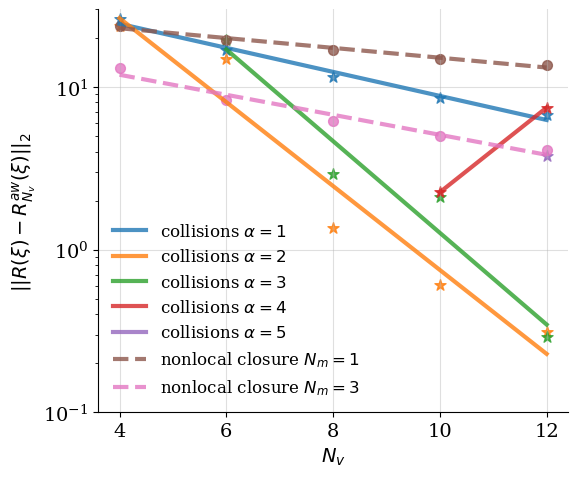

In [193]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(x, error_hyper1, color="tab:blue", marker="*", s=70, alpha=0.8)
ax.plot(x, 10**(a_hyper1*x + b_hyper1), linewidth=3, alpha=0.8, color="tab:blue", label=r"collisions $\alpha=1$")

ax.scatter(x, error_hyper2, color="tab:orange", marker="*", s=70, alpha=0.8)
ax.plot(x, 10**(a_hyper2*x + b_hyper2), linewidth=3, alpha=0.8, color="tab:orange", label=r"collisions $\alpha=2$")

ax.scatter(x[1:], error_hyper3, color="tab:green", marker="*", s=70, alpha=0.8)
ax.plot(x[1:], 10**(a_hyper3*x[1:] + b_hyper3), linewidth=3, alpha=0.8, color="tab:green", label=r"collisions $\alpha=3$")

ax.scatter(x[3:], error_hyper4, color="tab:red", marker="*", s=70, alpha=0.8)
ax.plot(x[3:], 10**(a_hyper4*x[3:] + b_hyper4), linewidth=3, alpha=0.8, color="tab:red", label=r"collisions $\alpha=4$")

ax.scatter(x[4:], error_hyper5, color="tab:purple", marker="*", s=70, alpha=0.8)
ax.plot(x[4:], 10**(a_hyper5*x[4:] + b_hyper5), linewidth=3, alpha=0.8, color="tab:purple", label=r"collisions $\alpha=5$")

ax.scatter(x, error_HP1, color="tab:brown", marker="o", s=50, alpha=0.8)
ax.plot(x, 10**(a_hp1*x + b_hp1), color="tab:brown", linewidth=3, ls="--", alpha=0.8, label=r"nonlocal closure $N_{m}=1$")

ax.scatter(x, error_HP2, color="tab:pink", marker="o", s=50, alpha=0.8)
ax.plot(x, 10**(a_hp2*x + b_hp2), color="tab:pink", linewidth=3, ls="--", alpha=0.8, label=r"nonlocal closure $N_{m}=3$")

ax.set_xticks([4, 6, 8, 10, 12])
ax.set_yscale("log")
ax.set_ylim(1e-1, 30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$||R(\xi) - R^{aw}_{N_{v}}(\xi)||_{2}$")
ax.set_xlabel(r"$N_{v}$")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc="lower left")
legend.get_frame().set_alpha(0)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("figs/symbolic_response_function_convergence.png", dpi=300, bbox_inches='tight')

## Landau damping dispersion relation

In [25]:
def get_landau_dispersion(func, xi_real, xi_imag, tol=1e-5):
    # initialize vectors 
    k_ = np.zeros(len(xi_real))*np.nan
    gr_ = np.zeros(len(xi_real))*np.nan
    # loop over to find minima
    for ii, xr in enumerate(xi_real):
        r_ = func(xi=xr + 1j*xi_imag) 
        if np.min(np.abs(np.imag(r_))) < tol:
            gr_[ii] = xi_imag[np.nanargmin(np.abs(r_.imag))]
            if r_[np.nanargmin(np.abs(np.imag(r_)))].real>=0:
                k_[ii] = np.sqrt(r_[np.nanargmin(np.abs(r_.imag))].real)
    return gr_[np.argsort(k_)], k_[np.argsort(k_)]

In [26]:
gr_true, k_true = get_landau_dispersion(func=R, xi_real=np.linspace(0, 5, int(1e4)), xi_imag=np.linspace(-1, 0, int(1e4)))

In [27]:
gr_hp3, k_hp3 = get_landau_dispersion(func=RHP3, xi_real=np.linspace(0, 7, int(1e4)), xi_imag=np.linspace(-0.8, 0, int(1e4)))

In [28]:
gr_hp4, k_hp4 = get_landau_dispersion(func=RHP4, xi_real=np.linspace(0, 6, int(1e4)), xi_imag=np.linspace(-0.75, 0, int(1e4)))

In [45]:
gr_l6, k_l6 = get_landau_dispersion(func=lambda xi: R4(xi, col=5), xi_real=np.linspace(0, 5, int(1e4)), xi_imag=np.linspace(-0.75, 0, int(1e4)), tol=5e-6)

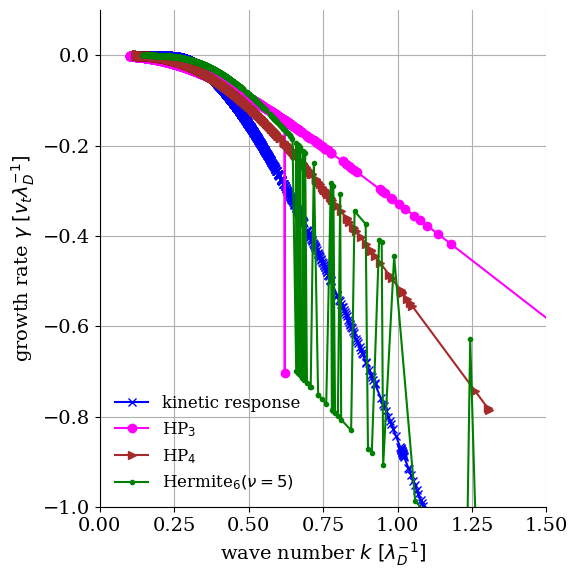

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3, label=r"HP$_{3}$", c="magenta", marker="o")
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4, label=r"HP$_{4}$", c="brown", marker=">")
ax.plot(k_l6,  gr_l6*np.sqrt(2)*k_l6, label=r"Hermite$_{6}(\nu=5)$ ", c="green", marker=".")

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
ax.set_ylim(-1, 0.1)
ax.set_xlim(0, 1.5)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("figs/landau_damping_hp_collisions.png", dpi=200)

## Bump-on-tail dispersion relation

In [53]:
# Despersion relation
def disp_k_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*R(xi=(xi-u2)) - (1-n1)*R(xi=((xi-u1)/T))

# Despersion relation
def disp_k_hp3_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*RHP3(xi=(xi-u2)) - (1-n1)*RHP3(xi=(xi-u1)/T)

# Despersion relation
def disp_k_hp4_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*RHP4(xi=(xi-u2)) -(1-n1)*RHP4(xi=(xi-u1)/T)

# Despersion relation
def disp_k_6_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*R6(xi=(xi-u2)) -(1-n1)*R6(xi=(xi-u1)/T)

In [54]:
gr_true, k_true = get_landau_dispersion(func=disp_k_bot, xi_real=np.linspace(1E-2, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [55]:
gr_hp3, k_hp3 = get_landau_dispersion(func=disp_k_hp3_bot, xi_real=np.linspace(0, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [56]:
gr_hp4, k_hp4 = get_landau_dispersion(func=disp_k_hp4_bot, xi_real=np.linspace(0, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [57]:
gr_l16, k_l16 = get_landau_dispersion(func=disp_k_6_bot, xi_real=np.linspace(0, 4, int(1e3)), xi_imag=np.linspace(0, 3, int(1e3)), tol=1e-3)

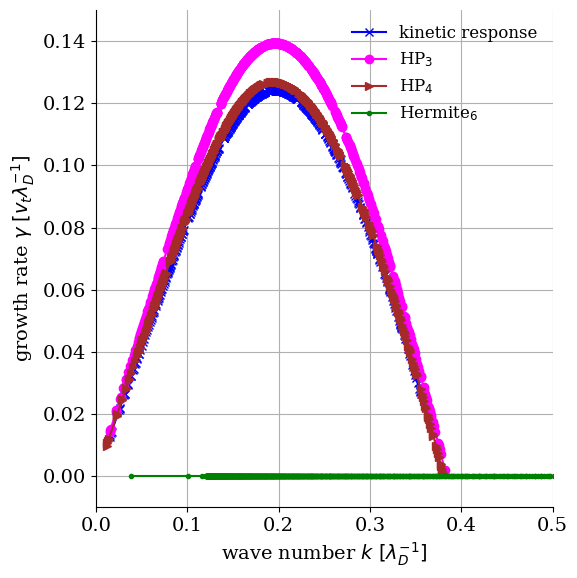

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3, label=r"HP$_{3}$", c="magenta", marker="o")
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4, label=r"HP$_{4}$", c="brown", marker=">")
ax.plot(k_l6,  gr_l6*np.sqrt(2)*k_l6, label=r"Hermite$_{6}$", c="green", marker=".")

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
ax.set_ylim(-0.01, 0.15)
ax.set_xlim(0., 0.5)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("figs/bump_on_tail_hp_collisions.png", dpi=200)